# Generating Text with an RNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 17.9 MB/s eta 0:00:00


In [ ]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
cd /content/drive/MyDrive/CS747_Assignment4/CS747_Assignment4


/content/drive/MyDrive/CS747_Assignment4/CS747_Assignment4


In [ ]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = 'language_data/shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 1115394
train len:  1003854
test len:  111540


In [ ]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

emain, as he says, your
pawn till it be brought you.

AUTOLYCUS:
I will trust you. Walk before toward the sea-side;
go on the right hand: I will but look upon the
hedge and follow you.

Clown:
We are b


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [ ]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [ ]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8, device=None):
    # Ensure the model is on the correct device
    rnn.to(device)

    # Initialize hidden state on the correct device
    hidden = rnn.init_hidden(1, device=device)

    # Move the hidden state to the correct device (if it's a tuple for LSTM)
    if isinstance(hidden, tuple):
        hidden = tuple(h.to(device) for h in hidden)
    else:
        hidden = hidden.to(device)

    # Convert prime string to tensor and move to the correct device
    prime_input = char_tensor(prime_str).to(device)
    predicted = prime_str

    # Build up the hidden state using the prime string
    for p in range(len(prime_str) - 1):
        char_tensor_input = prime_input[p].view(1).to(device)
        if isinstance(hidden, tuple):
            _, hidden = rnn(char_tensor_input, hidden)
        else:
            _, hidden = rnn(char_tensor_input, hidden)

    # Start generation with the last character of the prime string
    inp = prime_input[-1].view(1).to(device)

    for p in range(predict_len):
        inp = inp.to(device)

        # Ensure the hidden state is on the correct device
        if isinstance(hidden, tuple):
            hidden = tuple(h.to(device) for h in hidden)
        else:
            hidden = hidden.to(device)

        # Forward pass through the model
        if isinstance(hidden, tuple):
            output, hidden = rnn(inp, hidden)
        else:
            output, hidden = rnn(inp, hidden)

        # Sample from the output distribution using temperature
        output_dist = output.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Append the predicted character and use it as the next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char).view(1).to(device)

    return predicted


# Train RNN

In [ ]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [ ]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])

    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [ ]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function

    Returns:
    - loss: computed loss value as a Python float
    """
    # Initialize the hidden state
    hidden = rnn.init_hidden(input.size(0), device=device)

    # Zero the gradients
    optimizer.zero_grad()

    loss = 0

    # Loop over each time step in the input sequence
    for c in range(input.size(1)):
        output, hidden = rnn(input[:, c], hidden)
        # Compute loss for this time step
        step_loss = criterion(output.view(input.size(0), -1), target[:, c])
        loss += step_loss

    # Average the loss over the sequence length
    loss = loss / input.size(1)

    # Backpropagate the loss
    loss.backward()

    # Perform an optimization step
    optimizer.step()

    # Return the loss as a Python float
    return loss.item()


In [ ]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss

    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 34s (50 1%) train loss: 2.0823, test_loss: 2.1203]
Whe my me the that mumbat gord ands nous be so of my nous nous unot conk, and spoow ast Crwave dimy an 

 9s (100 2%) train loss: 1.9092, test_loss: 1.9794]
Whecour weling conceed,
No lath,
Qo for will preakese.

KING DICK:
He heep stake of sicour come contai 

 42s (150 3%) train loss: 1.8080, test_loss: 1.9225]
Whimbllome fies agemends in your maid our with Wike tome, and sunks;
If us a spaice his fenishil, not  

 16s (200 4%) train loss: 1.7636, test_loss: 1.8984]
When quellections thy mary thy lam, a for o' my for to my honout fouth for hair that but on,
The brian 

 50s (250 5%) train loss: 1.7248, test_loss: 1.8617]
Whinn give thencantion more be! and nesuint,
To that with the us pradiush tame begure this gord their  

 24s (300 6%) train loss: 1.6846, test_loss: 1.8182]
What in my muct
good pristor made to me a cullad inford. I manks in this spick
The grace fear I do he  

 58s (350 7%) train loss: 

In [ ]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

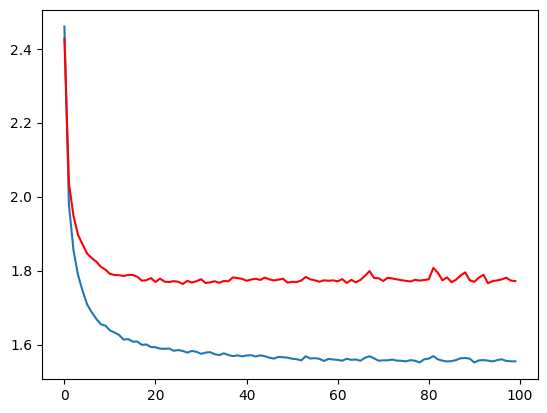

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(evaluate(rnn, prime_str='Th', predict_len=1000, device=device))


Th'R torgund't art have man, way,
If you here they my lord.

CLIFFORD:
The nower the highness.

LADY CAPULET:
They with him presister, lamel of all that with a giving every a man of heavy him noble allow him of lops it touth a pas to like to comploy: but hath have are by here let intortoo, with Richumber'd to swords!

Servingman:
Even with this world to dedice to the cannot stretch detale is nature
this; we day, my stand.

HENRY PERCY:
Now, that be charner prayer me thou must of my treys a grace infity?

CORIOLANUS:
I should have death.
The house.

SICINIUS:
Then swallow'd in which lordses, to moon would burty, and am, hear to so?

CLARENCE:
You here, you find fear the expeak thee, the great and by this leas your good time to sweet how thou art gone to make him can you gown'd that my banish of that ally here the countague up and be fear made it to live the should for the deloved face, fair'd prince
Of the is the tack'd, and bolse Montague, think
Will sing her peace sire the courtors,
W

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.


Training RNN model...
 43s (100/2000)] Train Loss: 2.4325, Test Loss: 2.0582
 26s (200/2000)] Train Loss: 1.8578, Test Loss: 1.8367
 9s (300/2000)] Train Loss: 1.6755, Test Loss: 1.7907
 51s (400/2000)] Train Loss: 1.5802, Test Loss: 1.7303
 35s (500/2000)] Train Loss: 1.5209, Test Loss: 1.6234
 18s (600/2000)] Train Loss: 1.4725, Test Loss: 1.6298
 1s (700/2000)] Train Loss: 1.4417, Test Loss: 1.6163
 44s (800/2000)] Train Loss: 1.4145, Test Loss: 1.6148
 27s (900/2000)] Train Loss: 1.3938, Test Loss: 1.5803
 10s (1000/2000)] Train Loss: 1.3757, Test Loss: 1.5964
 53s (1100/2000)] Train Loss: 1.3641, Test Loss: 1.5276
 37s (1200/2000)] Train Loss: 1.3486, Test Loss: 1.5772
 20s (1300/2000)] Train Loss: 1.3357, Test Loss: 1.5625
 4s (1400/2000)] Train Loss: 1.3267, Test Loss: 1.5693
 47s (1500/2000)] Train Loss: 1.3171, Test Loss: 1.4973
 30s (1600/2000)] Train Loss: 1.3088, Test Loss: 1.5493
 13s (1700/2000)] Train Loss: 1.2989, Test Loss: 1.4938
 56s (1800/2000)] Train Loss: 1.2956,

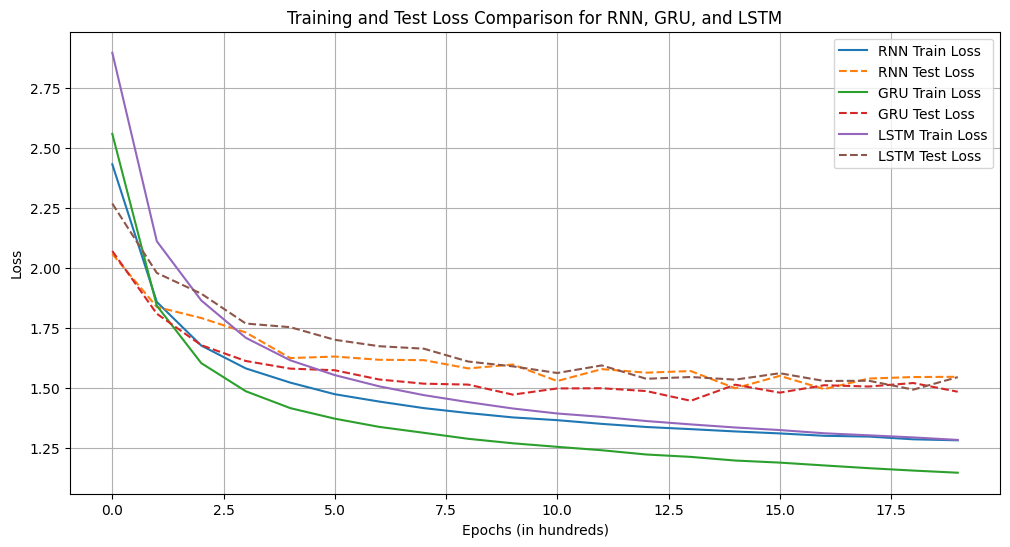

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from rnn.model import RNN
from rnn.helpers import load_random_batch, time_since, all_characters
from rnn.generate import generate

# Define hyperparameters
n_characters = len(all_characters)
hidden_size = 256  # Common hidden size for all models
n_layers = 2       # Number of RNN layers
learning_rate = 0.001
n_epochs = 2000    # Number of training epochs
batch_size = 100
chunk_len = 200
print_every = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize lists to store results
model_types = ["rnn", "gru", "lstm"]
train_losses = {}
test_losses = {}

# Define the training function
def train_model(model_type):
    rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
    rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    all_train_losses = []
    all_test_losses = []
    loss_avg = 0
    test_loss_avg = 0

    print(f"\nTraining {model_type.upper()} model...")

    start = time.time()
    for epoch in range(1, n_epochs + 1):
        input_data, target = load_random_batch(train_text, chunk_len, batch_size, device)
        hidden = rnn.init_hidden(batch_size, device)

        # Zero the gradients
        rnn_optimizer.zero_grad()

        # Forward pass
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(input_data[:, c], hidden)
            loss += criterion(output, target[:, c])

        # Backward pass
        loss.backward()
        rnn_optimizer.step()

        loss_avg += loss.item() / chunk_len

        # Evaluate on test set every 100 epochs
        if epoch % 100 == 0:
            test_input, test_target = load_random_batch(test_text, chunk_len, batch_size, device)
            test_hidden = rnn.init_hidden(batch_size, device)
            test_loss = 0
            with torch.no_grad():
                for c in range(chunk_len):
                    test_output, test_hidden = rnn(test_input[:, c], test_hidden)
                    test_loss += criterion(test_output, test_target[:, c])
            test_loss_avg = test_loss.item() / chunk_len

            # Store losses
            all_train_losses.append(loss_avg / 100)
            all_test_losses.append(test_loss_avg)

            print(f"[{time_since(start)} ({epoch}/{n_epochs})] Train Loss: {loss_avg / 100:.4f}, Test Loss: {test_loss_avg:.4f}")
            loss_avg = 0

    return all_train_losses, all_test_losses

# Train and store results for each model type
for model_type in model_types:
    train_losses[model_type], test_losses[model_type] = train_model(model_type)

# Plot the results
plt.figure(figsize=(12, 6))
for model_type in model_types:
    plt.plot(train_losses[model_type], label=f"{model_type.upper()} Train Loss")
    plt.plot(test_losses[model_type], label=f"{model_type.upper()} Test Loss", linestyle='--')

plt.xlabel("Epochs (in hundreds)")
plt.ylabel("Loss")
plt.title("Training and Test Loss Comparison for RNN, GRU, and LSTM")
plt.legend()
plt.grid()
plt.show()
